In [7]:
#Import library
#Data preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re

#Visualization
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

#Feature Engineering
import string
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

#Machine Learning Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout,Activation,Bidirectional
import tensorflow as tf

#Evaluation Metric
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjaymahto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sanjaymahto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
df = pd.read_csv('data/combined_data.csv')

In [10]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In this dataset:

'1' indicates that the email is classified as spam.
'0' denotes that the email is legitimate (ham).

In [11]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [12]:
df.shape

(83448, 2)

In [13]:
df['text'] = df['text'].str.lower()

**Remove Numbers and Special Character**

Often, characters, symbols, and numbers usually don't contribute to differentiating spam from legitimate emails

In [14]:
def remove_special_character(word):
    return word.translate(str.maketrans("", "", string.punctuation))

df['text'] = df['text'].apply(remove_special_character)

In [15]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


**Remove English stop-words**

Stopwords e like ‘the’, ‘a’,.... can be removed from the text because they don’t provide valuable information.

In [16]:
# Define Stop words 
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

def remove_stop_word(words):
    return [word for word in words if word not in ENGLISH_STOP_WORDS]

In [17]:
# Tokenize the text 
df['text'] = df['text'].apply(word_tokenize)

# Remove stop words 
df['text'] = df['text'].apply(remove_stop_word)

# Rejoin word for EDA 
df['text'] = df['text'].apply(' '.join)

In [18]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get medircations online qnb ikud viagra...
2,0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain prosperous future mon...
4,0,thanks answers guys know checked rsync manual ...


**Removal of hyperlinks**

Some emails contains URL which doesn't provide any valuable information.

In [19]:
def remove_hyper_link(words):
    return re.sub(r'http\s+', '', words)

df['text'] = df['text'].apply(remove_hyper_link)

In [22]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get medircations online qnb ikud viagra...
2,0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain prosperous future mon...
4,0,thanks answers guys know checked rsync manual ...


### Exploratory Data Analysis
**Let check with an example of a spam text**

In [25]:
for i in range(1, 3):
    print("Email #" + str(i))
    spam_email = df[df['label'] == 1]['text'].iloc[i]
    print(spam_email + "\n")

Email #1
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations confiden

In [26]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['label'] == 1]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
wulvob get medircations online qnb ikud viagra escapenumber escapenumber levitra escapenumber escapenumber cialis escapenumber escapenumber imitrex escapenumber escapenumber flonax escapenumber escapenumber ultram escapenumber escapenumber vioxx escapenumber escapenumber ambien escapenumber escapenumber valium escapenumber escapenumber xannax escapenumber escapenumber soma escapenumber meridia escapenumber escapenumber escapenumber escapenumber cysfrt ever stopped wonder much average man pays mediecines ap painkillers drugs improve quality life weight reducing tablets many escapenumber whats worse mediucine costs lot branded rfwur intrested dmvrwm remunerativ net dfuaeirxygiq visit website escapenumber

Email #2
university degree obtain prosperous future money earning power prestige comes career position youve always dreamed diploma prestigious non accredited unversities based present knowledge professional experience qualify required tests classes books examinations confiden

**Why those emails are classified as spam?**

Email 1: Medication Offers

- Unsolicited Advertising: The email is promoting medications like Viagra, Levitra, Cialis, and others, which is a common theme in spam emails.
- Random Words and Phrases: The message includes a mix of random words and pharmaceutical names, a tactic often used in spam to bypass filters.
- Suspicious Links: The mention of a website to visit for purchasing medications is a red flag. - Legitimate pharmaceutical companies typically don't market their products in such a manner.
- Irregular Formatting: Use of random characters and inconsistent spacing (e.g., "wulvob", "qnb ikud") is common in spam to evade detection algorithms.
- Lack of Personalization: The email is generic and does not address any recipient directly, implying it was sent to a mass audience.

**Email 2: Offering University Degrees**

- False Promises: Offering a university degree with no need for tests, classes, books, or exams is unrealistic and typical of educational scam emails.
- Anonymity: The assurance of confidentiality and the lack of any legitimate university names.
- 24/7 Availability: Claiming availability "24 hours a day, 7 days a week" is not typical for legitimate educational institutions.
- Lack of Specific Details: The email is vague about the nature of the degrees and the process, which is characteristic of spam.

**Therefore, the main characteristics of spam emails are often:**

Unsolicited Advertising: Spam emails often promote products or services without the recipient's prior consent.

Random and Irregular Text: They frequently contain a mix of random words, phrases, and characters to evade spam filters.

Deceptive Offers: Spam messages commonly include unrealistic or too-good-to-be-true offers, like quick degrees or cheap medications.

Lack of Personalization: These emails are typically generic, lacking direct addressing or personalization, indicating mass distribution.

Suspicious Links or Instructions: They often contain suspicious links or unclear instructions, potentially leading to phishing sites or scams.

Incoherent Content: The content in spam emails is often disjointed and lacks a clear, coherent message or purpose.

**Let check with an example of a legitimate text**

In [27]:
for i in range (1,3):
    print("Email #"+str(i))
    spam_email = df[df['label'] == 0]['text'].iloc[i]
    print(spam_email+"\n")

Email #1
thanks answers guys know checked rsync manual would rather get escapenumber sure answer one current script bin bash rsync avt exclude alpha exclude arm exclude hppa exclude hurd exclude iaescapenumber exclude mescapenumberk exclude mips exclude mipsel exclude multi arch exclude powerpc exclude sescapenumber exclude sh exclude sparc exclude source ftp de debian org debian cd var www mirror debian cd know loads excludes include distros soon rsync manual del alias delete delete delete extraneous files dest dirs delete receiver deletes transfer default delete receiver deletes xfer delete receiver deletes transfer delete excluded also delete excluded files dest dirs delete would suggest use thanks john escapelong escapenumber escapenumber escapenumber olleg samoylov wrote jonathan escapelong wrote sorry banal question favourite keys escapenumber stage rsync rsync verbose recursive links hard links times filter r tmp delete delay updates source url destination log file olleg samoylo

**Why those emails are classified as legitimate?**

Email 1: Technical Discussion

- Specific and Relevant Content: The email contains detailed, technical information about using rsync, a legitimate software tool, indicating a specific, purposeful discussion.
- Personalized and Contextual: The email is part of a conversation, with references to previous messages and specific individuals, showing it's targeted and relevant to the recipients.
- Professional Tone: The language and structure are professional and focused on a specific technical topic, which is typical in legitimate correspondence.
- No Unsolicited Offers or Links: There are no out-of-place promotions or suspicious links, which are common in spam

**Email 2: Legitimate Promotion**

- Official Communication: This email is from CNN, a recognized organization, promoting a scheduled show, which is a normal practice for media companies.
- Clear, Relevant Information: It provides detailed information about a specific event (interview with Michael Moore) and how to engage with it, indicating its legitimacy.
- Opt-in Confirmation: It mentions that the recipient has agreed to receive such emails, suggesting it's part of a legitimate subscription.
- Proper Unsubscribe Option: The presence of a clear unsubscribe option is a sign of legitimate marketing practices.

**Therefore, the main characteristics of legitimate emails are often:**

Relevant and Specific Content: Legitimate emails typically contain detailed, specific information related to the sender and recipient's shared context or interests.

Personalized Communication: They often address the recipient directly or reference previous interactions, indicating a personalized and targeted approach.

Professional and Coherent Tone: Legitimate emails usually maintain a professional, coherent language and tone, appropriate for the subject matter.

Affiliation with Recognized Entities: They are often associated with known organizations or entities, providing a layer of authenticity.

Opt-in and Unsubscribe Options: Legitimate commercial or promotional emails usually include clear options for opting in and unsubscribing, respecting recipient preferences.

Absence of Suspicious Links or Offers: Unlike spam, they typically do not contain unsolicited offers, misleading links, or requests for sensitive information.

**Spam email vs. Legitimate email chart**

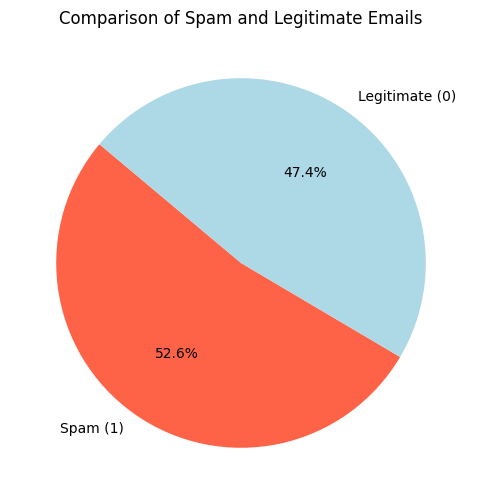

In [39]:
email_counts = df['label'].value_counts()

# Plotting 
plt.figure(figsize=(8, 6))
plt.pie(email_counts, labels=['Spam (1)', 'Legitimate (0)'], autopct='%1.1f%%', startangle=140, colors=['tomato', 'lightblue'])
plt.title('Comparison of Spam and Legitimate Emails')
plt.show()

The chart shows that 52.6% of the emails are classified as spam, while 47.4% are classified as legitimate. This nearly even split indicates that the dataset is fairly balanced between the two classes, which is good for training a machine learning model because it reduces the risk of the model being biased towards one class.

**Word Frequency Analysis**

Create a bar chart of the most frequent words in both spam and legitimate emails.

In [40]:
data = df.copy()

In [41]:
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get medircations online qnb ikud viagra...
2,0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain prosperous future mon...
4,0,thanks answers guys know checked rsync manual ...


In [42]:
spam_emails = df[df['label']==1]['text']
legit_emails = df[df['label']==0]['text']

In [43]:
spam_words = Counter()
spam_email.apply(lambda x: spam_words.update(x.split()))

0        None
1        None
3        None
8        None
9        None
         ... 
83439    None
83441    None
83444    None
83445    None
83447    None
Name: text, Length: 43910, dtype: object

In [44]:
# Count word frequencies for legitimate emails
legit_words = Counter()
legit_emails.apply(lambda x: legit_words.update(x.split()))

2        None
4        None
5        None
6        None
7        None
         ... 
83436    None
83440    None
83442    None
83443    None
83446    None
Name: text, Length: 39538, dtype: object

In [45]:
# Get the most common words in spam and legitimate emails
spam_common = spam_words.most_common(10)
legit_common = legit_words.most_common(10)

In [47]:
spam_common_df = pd.DataFrame(spam_common, columns=['Word', 'Frequency'])
legit_common_df = pd.DataFrame(legit_common, columns=['Word', 'Frequency'])

In [48]:
spam_common_df

,Word,Frequency
0,escapenumber,333240
1,escapelong,188103
2,com,29001
3,per,26141
4,x,23820
5,pills,23128
6,escapenumbermg,20541
7,price,18723
8,company,15872
9,one,15858


In [49]:
legit_common_df

,Word,Frequency
0,escapenumber,799937
1,r,53451
2,enron,52856
3,c,45222
4,org,42557
5,com,40681
6,escapelong,39075
7,ect,34743
8,help,32661
9,samba,30736


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'escapenumber'),
  Text(1, 0, 'r'),
  Text(2, 0, 'enron'),
  Text(3, 0, 'c'),
  Text(4, 0, 'org'),
  Text(5, 0, 'com'),
  Text(6, 0, 'escapelong'),
  Text(7, 0, 'ect'),
  Text(8, 0, 'help'),
  Text(9, 0, 'samba')])

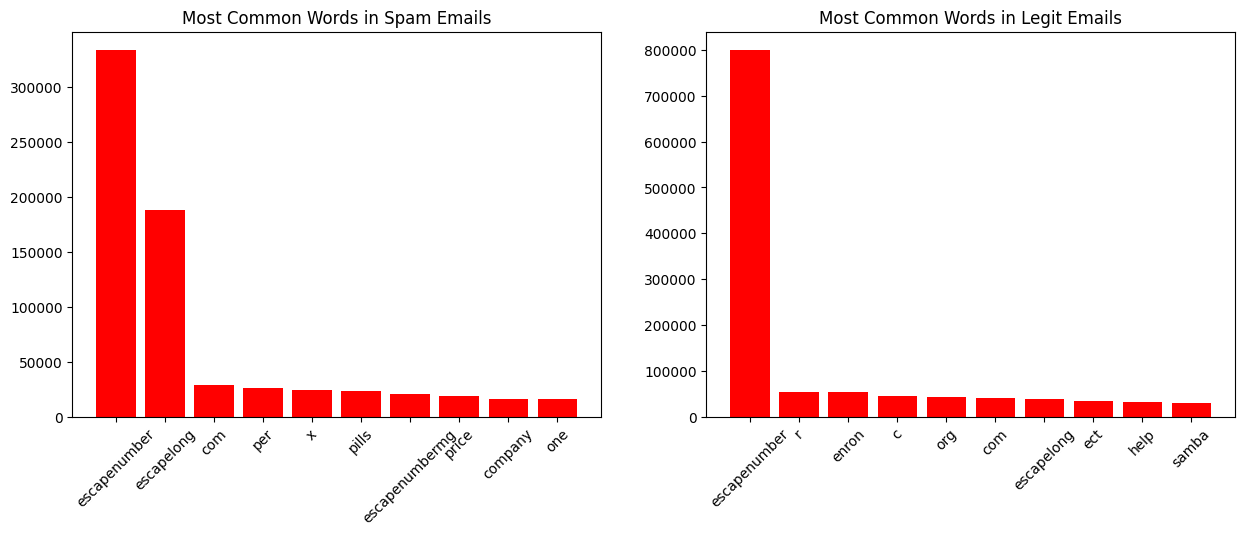

In [52]:
# Plotting the most common words in spam emails
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.bar(spam_common_df['Word'], spam_common_df['Frequency'], color='red')
plt.title('Most Common Words in Spam Emails')
plt.xticks(rotation=45)


plt.subplot(1, 2, 2)
plt.bar(legit_common_df['Word'], legit_common_df['Frequency'], color='red')
plt.title('Most Common Words in Legit Emails')
plt.xticks(rotation=45)

**Word Cloud**

Word clouds for spam and non-spam emails help visualize the most common words in each category.

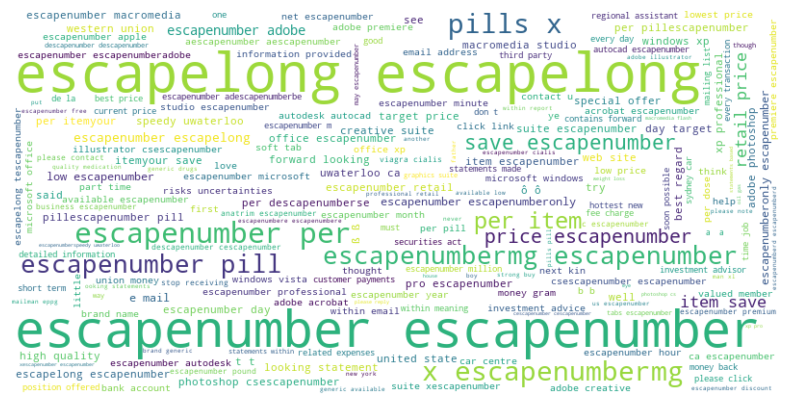

In [53]:
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(''.join(spam_emails))

# Display the image
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**N-gram Analysis**

The purpose of n-gram analysis is to explore the most common sequences of two or three words in spam and legitimate emails. This could help in understanding common phrases used in both types of emails.

In [54]:
# Extract n-grams from text
def generate_ngrams(text, n=2):
    # Split the text into words
    words = text.split()
    # Ensure that there is no enough words
    if len(words) >= n:
        return [' '.join(grams) for grams in ngrams(words, n)]
    else:
        return []

# Convert bigrams
df['bigrams'] = df['text'].apply(lambda x: generate_ngrams(x, n=2))

# count the frequencies
bigram_counts = Counter([bigram for sublist in df['bigrams'] for bigram in sublist])

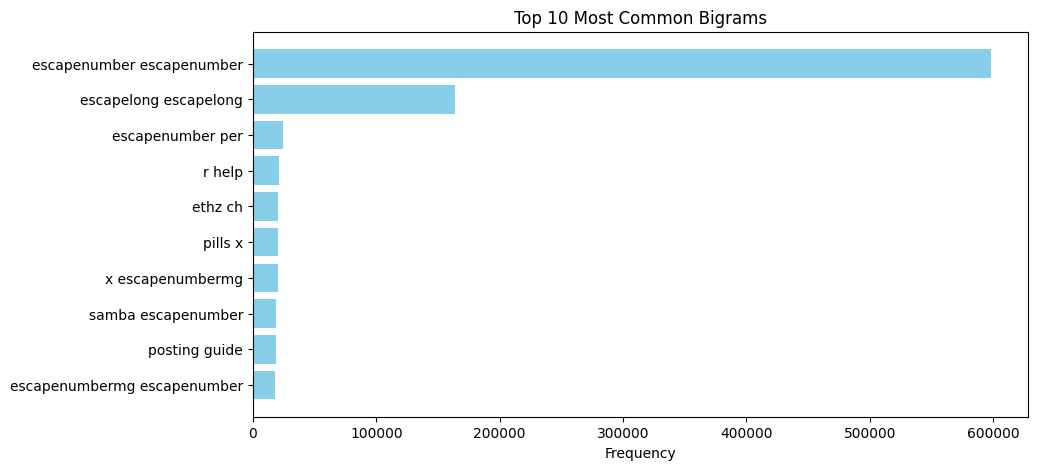

In [55]:
# Get the most common bigrams
most_common_bigrams = bigram_counts.most_common(10)

# Convert to DataFrame for visualization
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 5))
plt.barh(bigrams_df['Bigram'], bigrams_df['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Bigrams')
plt.gca().invert_yaxis()  # Display the highest count at the top
plt.show()

### Feature Engineering


**Spliting data into train and test set**

In [56]:
# Split the data into features and target
X = df['text']  
y = df['label']  

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**Tokenization**

Tokenization is the process of splitting text into smaller chunks, called tokens. Each token is an input to the machine learning algorithm as a feature.

In Python, keras.preprocessing.text.Tokenizer is a utility function that help tokenizes a text into tokens while keeping only the words that frequently occur. After tokenizing the text, we often end up with a massive dictionary of words which won’t all be necessary. One solution for this problem is setting ‘max_features’ to select the top frequent words that we want to consider.

In [57]:
max_feature = 5000

tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(X_train)

In [58]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [59]:
df.head()

,label,text,bigrams
0,1,ounce feather bowl hummingbird opec moment ala...,"[ounce feather, feather bowl, bowl hummingbird..."
1,1,wulvob get medircations online qnb ikud viagra...,"[wulvob get, get medircations, medircations on..."
2,0,computer connection cnn com wednesday escapenu...,"[computer connection, connection cnn, cnn com,..."
3,1,university degree obtain prosperous future mon...,"[university degree, degree obtain, obtain pros..."
4,0,thanks answers guys know checked rsync manual ...,"[thanks answers, answers guys, guys know, know..."


**Padding**

Padding is the step of making all tokens for all emails to equal size. Since we send input in batches of data points, information might be lost when inputs are of different sizes. So, making them the same size help eases batch updates.

In [60]:
#Average Length
average_length = df['text'].apply(len).mean()
print("Average Length: "+str(average_length))

Average Length: 1300.4678122902885


In [61]:
max_length = 500 #Set to average length

# Padding sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

**Label the encoding target variable**

The model expect the target variable as a number instead of string. Therefore, we can use a Label encoder to convert our target variable.

In [63]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

## Model Selection

To simplify with an example, let say we analyze a movie, which consists of a sequence of scenes. When we watch a scene, we can't understand the movie at whole, but rather in connection with previous scenes. Text works in a similar way, a machine learning model has to understand the text by utilizing already-learned text (like a human neural network).

For those reasons, Recurrent neural network (RNN) is a perfect fit. It has a repeating module that takes input from the previous stage and gives its output as input to the next stage. One limit of RNNs is that we can only retain information from the most recent stage. To learn long-term dependencies, our network needs memorization power. Therfore, Long Short Term Memory Networks (LSTMs) works perfectly to solve this problem.

In short, LSTMs are a special case of RNNs, which have similar chain-like structure as RNNs, but with a different repeating module structure. In this model, we will use Bi-directional LSTM. In a Bi-directional LSTM, the input sequence is fed in two ways: one from past to future and one from future to past. This can provide additional context to the network and result in a fuller understanding of the data.

In [64]:
embedding_vector_length = 32
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/Users/sanjaymahto/NLP-1/.conda/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
history = model.fit(X_train_padded, y_train_encoded, 
                    batch_size=512, 
                    epochs=10, 
                    validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9764 - loss: 0.0786 - val_accuracy: 0.9813 - val_loss: 0.0647
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9767 - loss: 0.0938 - val_accuracy: 0.9684 - val_loss: 0.1215
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9745 - loss: 0.0984 - val_accuracy: 0.9732 - val_loss: 0.0911
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9805 - loss: 0.0722 - val_accuracy: 0.9767 - val_loss: 0.0781
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.9841 - loss: 0.0480 - val_accuracy: 0.9764 - val_loss: 0.0698
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9806 - loss: 0.0527 - val_accuracy: 0.9700 - val_loss: 0.1171
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.9815 - loss: 0.0505 - val_accuracy: 0.9801 - val_loss: 0.0644
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9847 - loss: 0.0471 - val_accu

In summary, both training loss and accuracy show exceptional result, with the loss decreasing and accuracy over 99%, indicating effective learning on the training data. However, a key concern arises with the validation metrics such as the validation loss begins to increase after around the 5th epoch, and the validation accuracy starts to fluctuate and slightly decrease thereafter. This pattern, where the model performs exceptionally well on training data but less so on validation data, is a classic sign of overfitting. Further techniques are needed to address this problem.

## Performance Metrics


**Prediction and Evaluation**

In [ ]:
y_pred = model.predict(X_test_padded)
y_predict = [1 if o > 0.5 else 0 for o in y_pred]

In [ ]:
cf_matrix =confusion_matrix(y_test_encoded,y_predict)
tn, fp, fn, tp = confusion_matrix(y_test_encoded,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(y_test_encoded, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test_encoded, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test_encoded,y_predict)))

In [ ]:
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='')
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

This model is good model such as it has an F1 score of 96.68%. However, these result are only fit to this specific training dataset. When using this model to real-world data, we need to actively monitor the model's performance over time. We can also improve the model by responding to results and adding features to improve the result.